In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=10 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e+01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 24038 
    Total predicted counts          : 24169.15
    Total off counts                : 101782.00

    Total background counts         : 20356.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 1000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 5.52 s, sys: 11.7 ms, total: 5.53 s
Wall time: 5.54 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 24014 
    Total predicted counts          : 24144.75
    Total off counts                : 101660.00

    Total background counts         : 20332.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 23997 
    Total predicted counts          : 24110.55
    Total off counts                : 101489.00

    Total background counts         : 20

SpectrumDatasetOnOff

    Name                            : obs_18 

    Total counts                    : 24233 
    Total predicted counts          : 24104.55
    Total off counts                : 101459.00

    Total background counts         : 20291.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_19 

    Total counts                    : 24015 
    Total predicted counts          : 24099.75
    Total off counts                : 101435.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_33 

    Total counts                    : 24008 
    Total predicted counts          : 24013.75
    Total off counts                : 101005.00

    Total background counts         : 20201.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_34 

    Total counts                    : 23893 
    Total predicted counts          : 24171.55
    Total off counts                : 101794.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_47 

    Total counts                    : 24330 
    Total predicted counts          : 24201.55
    Total off counts                : 101944.00

    Total background counts         : 20388.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_48 

    Total counts                    : 23982 
    Total predicted counts          : 24199.75
    Total off counts                : 101935.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_62 

    Total counts                    : 24158 
    Total predicted counts          : 24134.95
    Total off counts                : 101611.00

    Total background counts         : 20322.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_63 

    Total counts                    : 24167 
    Total predicted counts          : 24074.75
    Total off counts                : 101310.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_77 

    Total counts                    : 24196 
    Total predicted counts          : 24110.15
    Total off counts                : 101487.00

    Total background counts         : 20297.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_78 

    Total counts                    : 24164 
    Total predicted counts          : 24159.95
    Total off counts                : 101736.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_95 

    Total counts                    : 23993 
    Total predicted counts          : 24118.95
    Total off counts                : 101531.00

    Total background counts         : 20306.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_96 

    Total counts                    : 24046 
    Total predicted counts          : 24101.15
    Total off counts                : 101442.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_113 

    Total counts                    : 24170 
    Total predicted counts          : 24074.75
    Total off counts                : 101310.00

    Total background counts         : 20262.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_114 

    Total counts                    : 24006 
    Total predicted counts          : 24170.35
    Total off counts                : 101788.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_130 

    Total counts                    : 24133 
    Total predicted counts          : 24048.35
    Total off counts                : 101178.00

    Total background counts         : 20235.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_131 

    Total counts                    : 24243 
    Total predicted counts          : 24180.95
    Total off counts                : 101841.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_153 

    Total counts                    : 24011 
    Total predicted counts          : 24060.55
    Total off counts                : 101239.00

    Total background counts         : 20247.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_154 

    Total counts                    : 23878 
    Total predicted counts          : 24050.55
    Total off counts                : 101189.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_176 

    Total counts                    : 24199 
    Total predicted counts          : 24103.15
    Total off counts                : 101452.00

    Total background counts         : 20290.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_177 

    Total counts                    : 24296 
    Total predicted counts          : 24126.95
    Total off counts                : 101571.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_200 

    Total counts                    : 24394 
    Total predicted counts          : 24168.95
    Total off counts                : 101781.00

    Total background counts         : 20356.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_201 

    Total counts                    : 24344 
    Total predicted counts          : 24112.75
    Total off counts                : 101500.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_221 

    Total counts                    : 23999 
    Total predicted counts          : 24102.15
    Total off counts                : 101447.00

    Total background counts         : 20289.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_222 

    Total counts                    : 23932 
    Total predicted counts          : 24220.15
    Total off counts                : 102037.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_245 

    Total counts                    : 24137 
    Total predicted counts          : 24109.75
    Total off counts                : 101485.00

    Total background counts         : 20297.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 0.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_246 

    Total counts                    : 24283 
    Total predicted counts          : 24084.55
    Total off counts                : 101359.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_267 

    Total counts                    : 24152 
    Total predicted counts          : 24123.55
    Total off counts                : 101554.00

    Total background counts         : 20310.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_268 

    Total counts                    : 24043 
    Total predicted counts          : 24031.95
    Total off counts                : 101096.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_286 

    Total counts                    : 24281 
    Total predicted counts          : 24083.95
    Total off counts                : 101356.00

    Total background counts         : 20271.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_287 

    Total counts                    : 24022 
    Total predicted counts          : 24137.55
    Total off counts                : 101624.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_310 

    Total counts                    : 24155 
    Total predicted counts          : 24138.75
    Total off counts                : 101630.00

    Total background counts         : 20326.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_311 

    Total counts                    : 24181 
    Total predicted counts          : 24189.55
    Total off counts                : 101884.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_332 

    Total counts                    : 24171 
    Total predicted counts          : 24121.35
    Total off counts                : 101543.00

    Total background counts         : 20308.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_333 

    Total counts                    : 24007 
    Total predicted counts          : 24055.15
    Total off counts                : 101212.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_357 

    Total counts                    : 24113 
    Total predicted counts          : 24030.95
    Total off counts                : 101091.00

    Total background counts         : 20218.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_358 

    Total counts                    : 23863 
    Total predicted counts          : 23992.55
    Total off counts                : 100899.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_376 

    Total counts                    : 24275 
    Total predicted counts          : 24220.95
    Total off counts                : 102041.00

    Total background counts         : 20408.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_377 

    Total counts                    : 24178 
    Total predicted counts          : 24248.55
    Total off counts                : 102179.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_401 

    Total counts                    : 24030 
    Total predicted counts          : 24087.35
    Total off counts                : 101373.00

    Total background counts         : 20274.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_402 

    Total counts                    : 24059 
    Total predicted counts          : 24124.35
    Total off counts                : 101558.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_415 

    Total counts                    : 24173 
    Total predicted counts          : 24119.55
    Total off counts                : 101534.00

    Total background counts         : 20306.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_416 

    Total counts                    : 24063 
    Total predicted counts          : 24039.15
    Total off counts                : 101132.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_432 

    Total counts                    : 24488 
    Total predicted counts          : 24167.15
    Total off counts                : 101772.00

    Total background counts         : 20354.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_433 

    Total counts                    : 24130 
    Total predicted counts          : 24110.55
    Total off counts                : 101489.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_452 

    Total counts                    : 24305 
    Total predicted counts          : 24104.95
    Total off counts                : 101461.00

    Total background counts         : 20292.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_453 

    Total counts                    : 24149 
    Total predicted counts          : 24256.15
    Total off counts                : 102217.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_474 

    Total counts                    : 23889 
    Total predicted counts          : 24188.55
    Total off counts                : 101879.00

    Total background counts         : 20375.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_475 

    Total counts                    : 23942 
    Total predicted counts          : 24122.55
    Total off counts                : 101549.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_493 

    Total counts                    : 24203 
    Total predicted counts          : 24053.35
    Total off counts                : 101203.00

    Total background counts         : 20240.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_494 

    Total counts                    : 24037 
    Total predicted counts          : 24161.15
    Total off counts                : 101742.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_511 

    Total counts                    : 24171 
    Total predicted counts          : 24058.35
    Total off counts                : 101228.00

    Total background counts         : 20245.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_512 

    Total counts                    : 23936 
    Total predicted counts          : 23988.55
    Total off counts                : 100879.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_527 

    Total counts                    : 24179 
    Total predicted counts          : 24128.15
    Total off counts                : 101577.00

    Total background counts         : 20315.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_528 

    Total counts                    : 23955 
    Total predicted counts          : 24081.15
    Total off counts                : 101342.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_544 

    Total counts                    : 24096 
    Total predicted counts          : 23994.95
    Total off counts                : 100911.00

    Total background counts         : 20182.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_545 

    Total counts                    : 24229 
    Total predicted counts          : 24118.95
    Total off counts                : 101531.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_562 

    Total counts                    : 24167 
    Total predicted counts          : 24104.75
    Total off counts                : 101460.00

    Total background counts         : 20292.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_563 

    Total counts                    : 24136 
    Total predicted counts          : 24057.95
    Total off counts                : 101226.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_577 

    Total counts                    : 23807 
    Total predicted counts          : 24071.15
    Total off counts                : 101292.00

    Total background counts         : 20258.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_578 

    Total counts                    : 24174 
    Total predicted counts          : 24195.15
    Total off counts                : 101912.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_592 

    Total counts                    : 24332 
    Total predicted counts          : 24134.75
    Total off counts                : 101610.00

    Total background counts         : 20322.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_593 

    Total counts                    : 24093 
    Total predicted counts          : 24071.95
    Total off counts                : 101296.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_610 

    Total counts                    : 24177 
    Total predicted counts          : 24161.95
    Total off counts                : 101746.00

    Total background counts         : 20349.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_611 

    Total counts                    : 24251 
    Total predicted counts          : 24057.95
    Total off counts                : 101226.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_627 

    Total counts                    : 24193 
    Total predicted counts          : 24037.35
    Total off counts                : 101123.00

    Total background counts         : 20224.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_628 

    Total counts                    : 23934 
    Total predicted counts          : 24204.75
    Total off counts                : 101960.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_642 

    Total counts                    : 23799 
    Total predicted counts          : 24228.35
    Total off counts                : 102078.00

    Total background counts         : 20415.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_643 

    Total counts                    : 24004 
    Total predicted counts          : 24082.55
    Total off counts                : 101349.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_658 

    Total counts                    : 24261 
    Total predicted counts          : 24099.95
    Total off counts                : 101436.00

    Total background counts         : 20287.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_659 

    Total counts                    : 24229 
    Total predicted counts          : 24104.15
    Total off counts                : 101457.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_673 

    Total counts                    : 24059 
    Total predicted counts          : 24125.95
    Total off counts                : 101566.00

    Total background counts         : 20313.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_674 

    Total counts                    : 24296 
    Total predicted counts          : 24097.35
    Total off counts                : 101423.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_692 

    Total counts                    : 24108 
    Total predicted counts          : 24120.75
    Total off counts                : 101540.00

    Total background counts         : 20308.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_693 

    Total counts                    : 24248 
    Total predicted counts          : 24135.15
    Total off counts                : 101612.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_713 

    Total counts                    : 23902 
    Total predicted counts          : 24123.15
    Total off counts                : 101552.00

    Total background counts         : 20310.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_714 

    Total counts                    : 23832 
    Total predicted counts          : 24119.15
    Total off counts                : 101532.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_736 

    Total counts                    : 24194 
    Total predicted counts          : 24107.35
    Total off counts                : 101473.00

    Total background counts         : 20294.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_737 

    Total counts                    : 23930 
    Total predicted counts          : 24128.95
    Total off counts                : 101581.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_753 

    Total counts                    : 24180 
    Total predicted counts          : 24084.15
    Total off counts                : 101357.00

    Total background counts         : 20271.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_754 

    Total counts                    : 24347 
    Total predicted counts          : 24071.75
    Total off counts                : 101295.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_768 

    Total counts                    : 24184 
    Total predicted counts          : 23983.95
    Total off counts                : 100856.00

    Total background counts         : 20171.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_769 

    Total counts                    : 24112 
    Total predicted counts          : 24150.95
    Total off counts                : 101691.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_780 

    Total counts                    : 24085 
    Total predicted counts          : 24161.15
    Total off counts                : 101742.00

    Total background counts         : 20348.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_781 

    Total counts                    : 24228 
    Total predicted counts          : 24083.75
    Total off counts                : 101355.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_792 

    Total counts                    : 24318 
    Total predicted counts          : 24024.35
    Total off counts                : 101058.00

    Total background counts         : 20211.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_793 

    Total counts                    : 24001 
    Total predicted counts          : 24101.95
    Total off counts                : 101446.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_812 

    Total counts                    : 24191 
    Total predicted counts          : 24167.75
    Total off counts                : 101775.00

    Total background counts         : 20355.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_813 

    Total counts                    : 23739 
    Total predicted counts          : 24078.75
    Total off counts                : 101330.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_837 

    Total counts                    : 24118 
    Total predicted counts          : 24058.35
    Total off counts                : 101228.00

    Total background counts         : 20245.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_838 

    Total counts                    : 24496 
    Total predicted counts          : 24228.95
    Total off counts                : 102081.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_854 

    Total counts                    : 24322 
    Total predicted counts          : 24184.95
    Total off counts                : 101861.00

    Total background counts         : 20372.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_855 

    Total counts                    : 24190 
    Total predicted counts          : 24171.15
    Total off counts                : 101792.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_871 

    Total counts                    : 24139 
    Total predicted counts          : 24094.15
    Total off counts                : 101407.00

    Total background counts         : 20281.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_872 

    Total counts                    : 24154 
    Total predicted counts          : 24117.55
    Total off counts                : 101524.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_883 

    Total counts                    : 24186 
    Total predicted counts          : 24242.15
    Total off counts                : 102147.00

    Total background counts         : 20429.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_884 

    Total counts                    : 23952 
    Total predicted counts          : 24157.15
    Total off counts                : 101722.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_896 

    Total counts                    : 24168 
    Total predicted counts          : 24067.95
    Total off counts                : 101276.00

    Total background counts         : 20255.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_897 

    Total counts                    : 24201 
    Total predicted counts          : 23986.95
    Total off counts                : 100871.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_910 

    Total counts                    : 24591 
    Total predicted counts          : 24224.15
    Total off counts                : 102057.00

    Total background counts         : 20411.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_911 

    Total counts                    : 23828 
    Total predicted counts          : 24171.55
    Total off counts                : 101794.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_924 

    Total counts                    : 24149 
    Total predicted counts          : 24038.15
    Total off counts                : 101127.00

    Total background counts         : 20225.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_925 

    Total counts                    : 24247 
    Total predicted counts          : 24137.55
    Total off counts                : 101624.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_936 

    Total counts                    : 24076 
    Total predicted counts          : 24187.35
    Total off counts                : 101873.00

    Total background counts         : 20374.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_937 

    Total counts                    : 24273 
    Total predicted counts          : 24255.95
    Total off counts                : 102216.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_951 

    Total counts                    : 24168 
    Total predicted counts          : 24292.55
    Total off counts                : 102399.00

    Total background counts         : 20479.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_952 

    Total counts                    : 24079 
    Total predicted counts          : 24092.55
    Total off counts                : 101399.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_965 

    Total counts                    : 24214 
    Total predicted counts          : 23961.55
    Total off counts                : 100744.00

    Total background counts         : 20148.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_966 

    Total counts                    : 24135 
    Total predicted counts          : 24116.55
    Total off counts                : 101519.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_978 

    Total counts                    : 23921 
    Total predicted counts          : 24127.15
    Total off counts                : 101572.00

    Total background counts         : 20314.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_979 

    Total counts                    : 24056 
    Total predicted counts          : 24131.55
    Total off counts                : 101594.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_993 

    Total counts                    : 23877 
    Total predicted counts          : 24038.55
    Total off counts                : 101129.00

    Total background counts         : 20225.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_994 

    Total counts                    : 23834 
    Total predicted counts          : 24058.55
    Total off counts                : 101229.00

    Total background counts        

Text(0, 0.5, 'No. of observations')

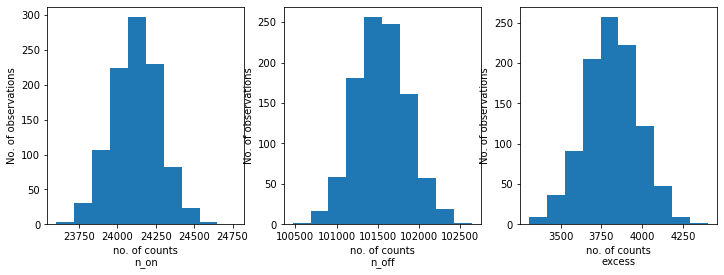

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

/home/rishank/anaconda2/envs/gammapy-0.12/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/rishank/anaconda2/envs/gammapy-0.12/lib/python3.6/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: overflow encountered in square
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/home/rishank/anaconda2/envs/gammapy-0.12/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


CPU times: user 12min 21s, sys: 9.96 s, total: 12min 31s
Wall time: 12min 38s


In [15]:
results

[{'index': 2.4975163841672487,
  'amplitude': 4.827170694526582e-13,
  'lambda_': 7.485856296750121},
 {'index': 1.4374990905086065,
  'amplitude': 1.95162010050395e-11,
  'lambda_': 18.076892826494696},
 {'index': 2.1109858677579965,
  'amplitude': 2.074618615585857e-12,
  'lambda_': 12.009647842508233},
 {'index': 2.3005350088685796,
  'amplitude': 9.89055489086283e-13,
  'lambda_': 9.681659958321784},
 {'index': 2.230976533256663,
  'amplitude': 1.3164403845882905e-12,
  'lambda_': 9.985873117198194},
 {'index': 2.0628105176578253,
  'amplitude': 2.196492176279271e-12,
  'lambda_': 11.71655274212883},
 {'index': 1.8734099312197747,
  'amplitude': 3.8471926658661285e-12,
  'lambda_': 12.275782469133155},
 {'index': 2.0939875156321897,
  'amplitude': 2.2267644932909613e-12,
  'lambda_': 12.237363193729184},
 {'index': 2.1572876506032355,
  'amplitude': 1.54807964057516e-12,
  'lambda_': 11.089266643557096},
 {'index': 2.2406918727253804,
  'amplitude': 1.2651166555099367e-12,
  'lambd

index: 2.1474148230949934 += 0.4188893148094318


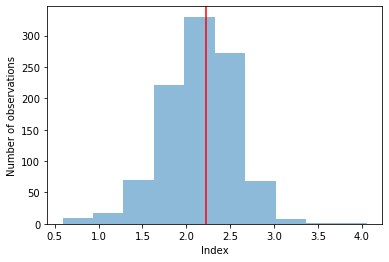

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 6.5023406574683366e-12 += 2.573798624467484e-11


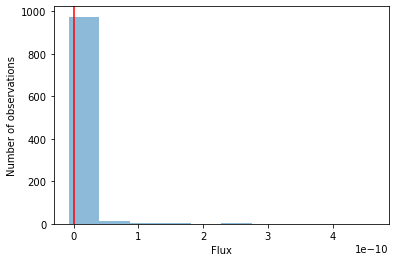

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 10.808407642472076 += 4.346424161332559


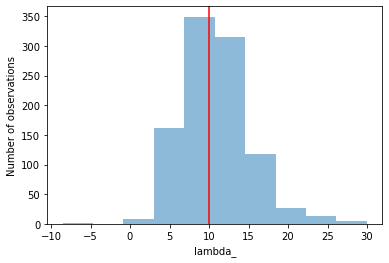

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")